In [2]:
using ITensors, ITensorMPS, PythonPlot

# Reset global variables
global psi = []
global energies = []
global sorted_indices = []
global overlap_matrix = nothing

# Number of states to find
global R = 10  

# Length of the spin chain
global L = 30 

# Create L Spin-1/2 Indices
global sites = siteinds("S=1/2", L)

let
    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
        # Boundary terms
        osI -= "X", L
        osI -= "Z", L, "Z", 1
        HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
        # Boundary terms
        os3 += "X", L - 1, "Z", L, "Z", 1
        os3 += "X", L, "Z", 1, "Z", 2
        os3 += "Z", L - 1, "Z", L, "X", 1
        os3 += "Z", L, "Z", 1, "X", 2
        H3 = MPO(os3, sites)

    # Coupling coefficients
        lambdaI = 3/2
        lambda3 = 1/2

    # Adding energy offset E0
        # EO = L * (lambdaI^2 + lambda3^2) / lambda3
        # osEO = OpSum()
        #     osEO += EO, "Id", 1
        # E0 = MPO(osEO, sites)

    # Full Hamiltonian from paper
        H = 2 * lambdaI * HI + lambda3 * H3 # + E0

    # Create an initial random matrix product state
        psi0 = random_mps(sites)
    
    # Set the number of sweeps, bond dimensions, and cutoff for the DMRG algorithm
        nsweeps = 20
        maxdim = [10, 33, 66, 133]
        cutoff = 1.0e-8

    println("Maxdim per sweep: ", maxdim)
    println()
    
    # Run DMRG R times to find R states
    global psi = Vector{MPS}(undef, R)
    global energies = zeros(R)

        # Run DMRG once to find a ground state
        println("DMRG run 1:")
        observer = DMRGObserver(; energy_tol=1e-8) # Observer to monitor convergence
        energies[1], psi[1] = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
        println("Final energy for DMRG run 1: $(energies[1])")
        println()

        # Find subsequent states while forcing orthogonality
        for i in 2:R
            println("DMRG run $i:")
            energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, maxdim, cutoff, weight=100, observer=observer)
            println("Final energy for DMRG run $i: $(energies[i])")
            println()
        end

    # Sort and label the states
    global sorted_indices = sortperm(energies)

    println("Energy results from DMRG in ascending order:")
    for (i, idx) in enumerate(sorted_indices)
        println("State $i: $(energies[idx])")
    end
    
    # Analysis overlap between states; Return overlap matrix
    function analyze_overlaps(psi, sorted_indices...,)
        n_total = length(sorted_indices)

        # Create an overlap matrix
        overlap_matrix = zeros(ComplexF64, n_total, n_total)

        # Compute the overlaps
        for (i, idx_i) in enumerate(sorted_indices)
            for (j, idx_j) in enumerate(sorted_indices)
                overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
            end
        end

        # Check normalizations
        println("\nNormalizations:")
        for (i, idx) in enumerate(sorted_indices)
            norm_val = abs(overlap_matrix[i,i])
            println("State $i: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=8))")
        end

        # Check Orthogonality
        println("\nInner product between states:")
        for i in 1:n_total
            for j in (i+1):n_total
                overlap_val = abs(overlap_matrix[i,j])
                println("⟨ψ$(sorted_indices[i])|ψ$(sorted_indices[j])⟩ = $overlap_val")
            end
        end
        
        return overlap_matrix
    end

    global overlap_matrix = analyze_overlaps(psi, sorted_indices...,)

    nothing
end

Maxdim per sweep: [10, 33, 66, 133]

DMRG run 1:
After sweep 1 energy=-102.4901598594962  maxlinkdim=4 maxerr=1.11E-15 time=17.137
After sweep 2 energy=-103.96564065844854  maxlinkdim=15 maxerr=9.33E-09 time=0.079
After sweep 3 energy=-104.23858027486622  maxlinkdim=31 maxerr=9.86E-09 time=0.239
After sweep 4 energy=-104.2725984577321  maxlinkdim=40 maxerr=9.98E-09 time=0.377
After sweep 5 energy=-104.28103876217534  maxlinkdim=48 maxerr=9.91E-09 time=0.471
After sweep 6 energy=-104.28194090683643  maxlinkdim=52 maxerr=9.97E-09 time=0.544
After sweep 7 energy=-104.28197563837307  maxlinkdim=46 maxerr=9.99E-09 time=0.502
After sweep 8 energy=-104.2819760157828  maxlinkdim=45 maxerr=9.98E-09 time=0.493
After sweep 9 energy=-104.28197575526386  maxlinkdim=45 maxerr=9.98E-09 time=0.445
After sweep 10 energy=-104.2819757154074  maxlinkdim=44 maxerr=9.86E-09 time=0.467
After sweep 11 energy=-104.28197571616501  maxlinkdim=44 maxerr=9.76E-09 time=0.442
Energy difference less than 1.0e-8, stop

Maximum and Minimum Correlations:
State 1: 0.634078, 0.371126
State 2: 0.680843, 0.528797
State 3: 0.626756, 0.04483
State 5: 0.660982, 0.02905
State 4: 0.505758, 0.004718
State 7: 0.62126, 0.0113
State 6: 0.618231, 0.010395
State 8: 0.61844, 0.003575
State 9: 0.639758, 0.005566
State 10: 0.64608, 0.001361


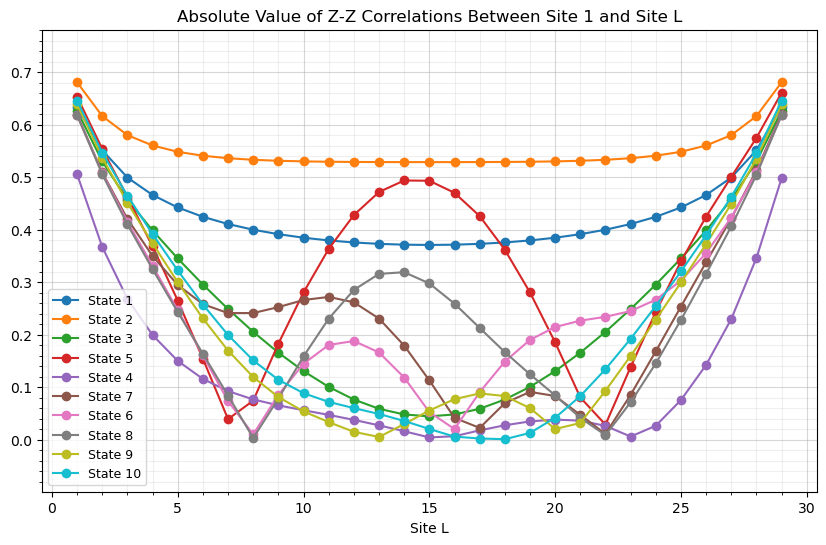

In [3]:
using PythonPlot

# Clear variables
ZZC = Vector{Matrix{ComplexF64}}(undef, R)
abs_ZZC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute Z-Z correlations matrices for all states
for i in 1:R
    ZZC[i] = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
end

# Get the absolute values of correlations
for i in 1:R
    abs_ZZC[i] = abs.(ZZC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
for i in 1:R
    x[i] = collect(1:length(abs_ZZC[i]))
    plot(x[i], abs_ZZC[i], marker="o", linestyle="-", linewidth=1.5,
        label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel("Site L")
title("Absolute Value of Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()
   
# Adjust graph
ymax = max([maximum(abs_ZZC[i]) for i in 1:R]...)
ymin = min([minimum(abs_ZZC[i]) for i in 1:R]...)
ylim(ymin - 0.1, ymax + 0.1)

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(abs_ZZC[i]), digits=6)), $(round(minimum(abs_ZZC[i]), digits=6))")
end

Maximum and Minimum Correlations:
State 1: 0.551417, 0.404378
State 2: 0.480842, 0.34065
State 3: 0.530141, 0.398799
State 5: 0.484026, 0.330034
State 4: 0.709662, 0.443914
State 6: 0.514133, 0.350204
State 7: 0.504733, 0.353224
State 8: 0.510102, 0.356391
State 9: 0.506849, 0.357876
State 10: 0.471918, 0.339712


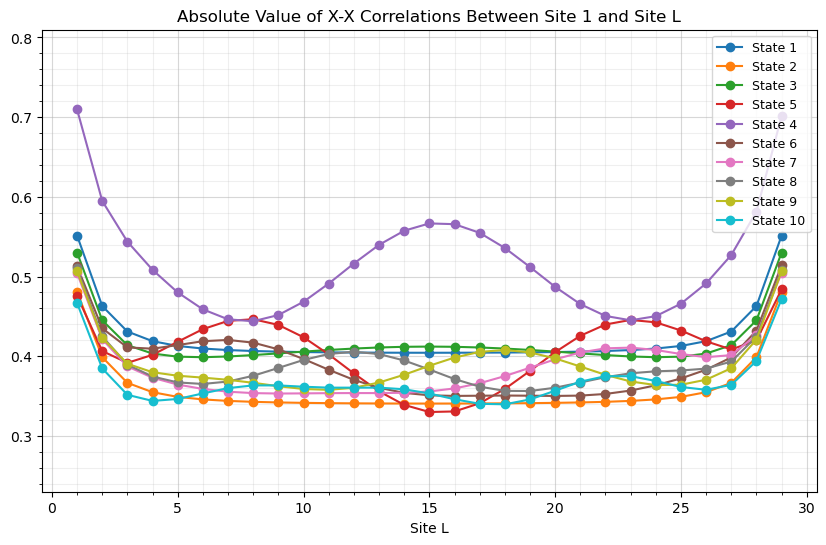

In [48]:
using PythonPlot

# Clear variables
XXC = Vector{Matrix{ComplexF64}}(undef, R)
abs_XXC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute X-X correlations matrices for all states
for i in 1:R
    XXC[i] = correlation_matrix(psi[sorted_indices[i]], "X", "X")
end

# Get the absolute values of correlations
for i in 1:R
    abs_XXC[i] = abs.(XXC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the X-X correlations for ground states
for i in 1:R
    x[i] = collect(1:length(abs_XXC[i]))
    plot(x[i], abs_XXC[i], marker="o", linestyle="-", linewidth=1.5,
        label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel("Site L")
title("Absolute Value of X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()
   
# Adjust graph
ymax = max([maximum(abs_XXC[i]) for i in 1:R]...)
ymin = min([minimum(abs_XXC[i]) for i in 1:R]...)
ylim(ymin - 0.1, ymax + 0.1)

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(abs_XXC[i]), digits=6)), $(round(minimum(abs_XXC[i]), digits=6))")
end